In [5]:
import warnings
import numpy as np
from hmmlearn import hmm
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from googlefinance.client import get_price_data

# add a warning suppressing
warnings.filterwarnings("ignore")

<h1> Hidden Markov Models </h1><br>Application the GBPEUR Exchange rate overe the last five years
<br>
The data will be downloaded using the <i>googlefinance client </i><br>
Note that the hmm is no longer part of sklearn (release 0.17). The command <i>pip install hmmlearn</i> is required.

In [6]:
param_GBP = {'q': "GBPEUR","p" : "5Y",'i': "86400"}
df = get_price_data(param_GBP)['Close'].to_frame()

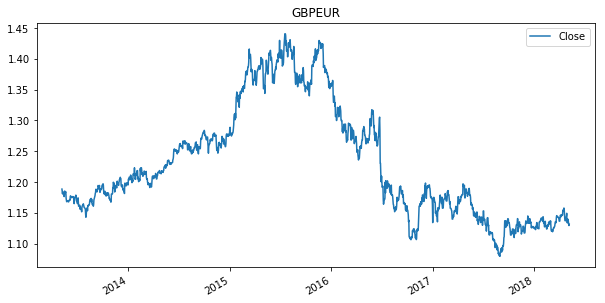

In [7]:
df.plot(figsize=(10,5),title='GBPEUR');

Calculating (log) returns for the dataset

In [8]:
df['Ret']= df['Close'].pct_change(periods=1)
df['LogRet'] = df['Ret'].apply(lambda x: np.log(1+x))
df.dropna(how='any',inplace=True)

We opt for a hidden markov model with <b>3 hidden states </b>. Each state has a <b> Gaussian Emission </b> to visible states. The visible states are the sequence of daily logreturns observed for the GBPEUR Exchange Rate.

In [9]:
X = df['LogRet'].reshape(-1,1)
model = hmm.GaussianHMM(n_components=3, covariance_type="full")
model.fit(X)

GaussianHMM(algorithm='viterbi', covariance_type='full', covars_prior=0.01,
      covars_weight=1, init_params='stmc', means_prior=0, means_weight=0,
      min_covar=0.001, n_components=3, n_iter=10, params='stmc',
      random_state=None, startprob_prior=1.0, tol=0.01, transmat_prior=1.0,
      verbose=False)

Fitting the model to the data will reveal information on :
<ol>
<li> The transition matrix "orchestrating" the way that the hidden states move between each other. 
<li> The Emission from each of the hidden states to the visible states takes Gaussian model (mean + variance)
</ol>

In [10]:
print('transition matrix')
pd.DataFrame(model.transmat_)

transition matrix


,0,1,2
0,0.374309,0.421907,0.203784
1,0.374819,0.422709,0.202473
2,0.366572,0.411429,0.221999


In [11]:
print('Means of the Gaussians')
print(model.means_.ravel())
print('Hidden State 0 is producing random normal numbers with mean ',np.round(np.float(model.means_[0]),8))

Means of the Gaussians
[ 1.93104819e-05  4.06121109e-05 -2.51273657e-04]
Hidden State 0 is producing random normal numbers with mean  1.931e-05


In [12]:
print('Standard deviations')
print(np.sqrt(model.covars_.ravel())*100)

Standard deviations
[0.56332859 0.53467822 0.85203711]


The first two states generate returns with a very similar standard deviation and it makes sense to group these together.
Both hidden states have also positive returns. <br>
<b>=>Opting for 2 hidden states</b>

In [13]:
model = hmm.GaussianHMM(n_components=2, covariance_type="full")
model.fit(X)

GaussianHMM(algorithm='viterbi', covariance_type='full', covars_prior=0.01,
      covars_weight=1, init_params='stmc', means_prior=0, means_weight=0,
      min_covar=0.001, n_components=2, n_iter=10, params='stmc',
      random_state=None, startprob_prior=1.0, tol=0.01, transmat_prior=1.0,
      verbose=False)

In [14]:
print('transition matrix')
print(pd.DataFrame(model.transmat_))
print('\nWhat do these data tell you ?\nWhat is the most frequent state?')

transition matrix
          0         1
0  0.370112  0.629888
1  0.350053  0.649947

What do these data tell you ?
What is the most frequent state?


In [15]:
print('Means of the Gaussians')
print(model.means_.ravel())

Means of the Gaussians
[-2.26241672e-04  8.25557865e-05]


In [16]:
print('Standard deviations')
print(np.sqrt(model.covars_.ravel())*100)

Standard deviations
[0.73212859 0.46804285]


From the sequence $X$ (= observed log returns), one can derive the corresponding hidden states. This done using the <b>Viterbi</b> algortihm

In [17]:
Z = model.predict(X).reshape(-1,1)

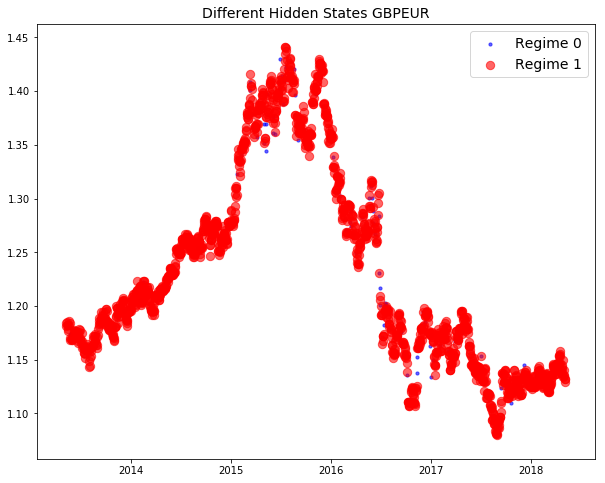

In [18]:
fig = plt.subplots(1,1,figsize=(10,8))
color = ['b','r']
size = [10,70]
for z , c , s , i in zip(np.unique(Z),
                         color,size,
                         np.arange(0,len(model.means_))):
    idx = Z ==z
    plt.scatter(df[Z==z].index,
                df[Z==z]['Close'],
                c=c,
                s=s,
                alpha=0.6,
               label='Regime '+str(i))
plt.title('Different Hidden States GBPEUR',fontsize=14);
plt.legend(loc=1,fontsize=14);

Can we plot the evolution of the "High Volatility Regime" post / pre Brexit ?
<br>In a rolling window of 250 days, we can count the number of high volatility days<br>

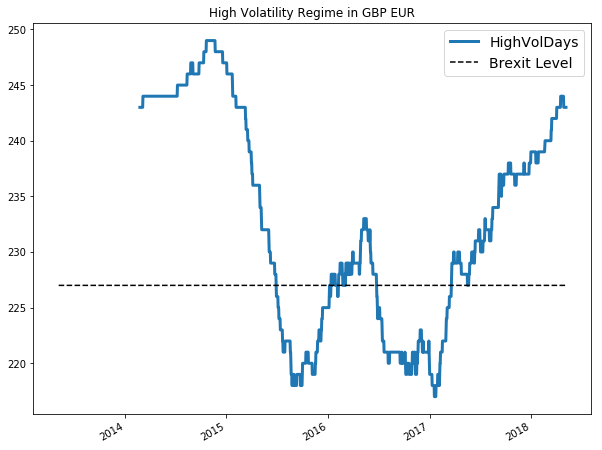

In [19]:
df['Regime']= Z
df['HighVolDays']=df['Regime'].rolling(window=250).apply(lambda x : np.sum(x==1))
df['HighVolDays'].plot(figsize=(10,8),title='High Volatility Regime in GBP EUR',linewidth=3);
df['Nbr'] = df.loc['20160624',['HighVolDays']].values[0,0]
df['Nbr'].plot(c='k',label='Brexit Level',linestyle='dashed');
plt.legend(fontsize=14)